

*Original code by Ryan S. McGee. Modified by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens.*

Copyright (c) 2020 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

This notebook accompanies our preprint: "*A deterministic, age-stratified, extended SEIRD model for assessing the effect of non-pharmaceutical interventions on SARS-CoV-2 spread in Belgium*"(https://doi.org/10.1101/2020.07.17.20156034)

# Load required packages

In [1]:
import random
import os
import numpy as np
import json
import corner
import random

import pandas as pd
import datetime
import scipy
import matplotlib.dates as mdates
import matplotlib
import math
import xarray as xr
import emcee
import matplotlib.pyplot as plt
import datetime

from covid19model.optimization import objective_fcns,pso
from covid19model.models import models
from covid19model.models.utils import draw_sample_COVID19_SEIRD_google
from covid19model.models.time_dependant_parameter_fncs import google_lockdown, ramp_fun, contact_matrix
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import model_parameters
from covid19model.visualization.output import population_status, infected, _apply_tick_locator 
from covid19model.visualization.optimization import plot_fit, traceplot


# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Load data

In [2]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = model_parameters.get_interaction_matrices(dataset='willem_2012')
levels = initN.size
Nc_all = {'total': Nc_total, 'home':Nc_home, 'work': Nc_work, 'schools': Nc_schools, 'transport': Nc_transport, 'leisure': Nc_leisure, 'others': Nc_others}


In [3]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail(2)

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-11-17,6240,1356,372,670,5507,118,0.0,9.0,14,45,50
2020-11-18,5897,1325,353,562,5298,18,0.0,1.0,4,8,5


In [4]:
df_google = google.get_google_mobility_data(update=False, plot=False)
df_google.tail(2)

,retail_recreation,grocery,parks,transport,work,residential
date,,,,,,
2020-11-14,-57.0,-10.0,47.0,-38.0,-22.0,13.0
2020-11-15,-65.0,-20.0,-27.0,-50.0,-23.0,11.0


In [ ]:

# def switch_beta(t,param,samples_dict):
#     if t < pd.to_datetime('2020-05-04'):
#         return np.random.choice(samples_dict['beta'],1,replace=False)
#     elif pd.to_datetime('2020-05-04') < t <= pd.to_datetime('2020-09-01'):
#         return np.random.choice(samples_dict['beta_summer'],1,replace=False)
#     else:
#         return np.random.choice(samples_dict['beta'],1,replace=False)

# Wave 1 - March 2020 - September 2020

In [18]:
def wave1_policies(t,param,df_google, Nc_all, l , tau, 
                   prev_schools, prev_work, prev_transport, prev_leisure, prev_others, prev_home):
    
    # Convert tau and l to dates
    tau_days = pd.Timedelta(tau, unit='D')
    l_days = pd.Timedelta(l, unit='D')

    # Define additional dates where intensity or school policy changes
    t1 = pd.Timestamp('2020-03-15') # start of lockdown
    t2 = pd.Timestamp('2020-05-18') # gradual re-opening of schools (15%)
    t3 = pd.Timestamp('2020-06-04') # further re-opening of schools (65%)
    t4 = pd.Timestamp('2020-07-01') # closing schools (end calibration wave1)

    if t <= t1 + tau_days:
        return contact_matrix(t, df_google, Nc_all, school=1)
    elif t1 + tau_days < t <= t1 + tau_days + l_days:
        policy_old = contact_matrix(t, df_google, Nc_all, school=1)
        policy_new = contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                                    prev_leisure, prev_others, school=0)
        return ramp_fun(policy_old, policy_new, t, tau_days, l, t1)
    elif t1 + tau_days + l_days < t <= t2:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0)
    elif t2 < t <= t3:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0.15)
    elif t3 < t <= t4:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0.65)
    else:
        return contact_matrix(t, df_google, Nc_all, prev_home, prev_schools, prev_work, prev_transport, 
                              prev_leisure, prev_others, school=0)


In [24]:
#### Load the model parameters using `get_COVID19_SEIRD_parameters()`.
params = model_parameters.get_COVID19_SEIRD_parameters()

params.update({'df_google': df_google,
              'Nc_all' : Nc_all,
               'l' : 5,
               'tau' : 5,
               'prev_schools': 0.5,
               'prev_work': 0.5,
               'prev_transport': 0.5,
               'prev_leisure': 0.5,
               'prev_others': 0.5,
               'prev_home' : 0.5
              })

# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': wave1_policies})

## Perform calibration

In [30]:
# Date of first data collection
start_calibration = '2020-03-15'
# Last datapoint used to calibrate basic reproduction number
end_calibration = '2020-07-01'

# Path where figures should be stored
fig_path = '../../results/calibrations/COVID19_SEIRD/national/'
# Path where MCMC samples should be saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'
# Spatial unit: Belgium
spatial_unit = 'BE_with_6_prev'

In [32]:
init_warmup = 30
maxiter = 100
popsize = 100
processes = 32 # voor eraser!! ## PROCESSES=1 to debug!
steps_mcmc = 50#3000
discard = 0#1000

# define dataset
data=[df_sciensano['H_in'][start_calibration:end_calibration]]
states = [["H_in"]]

####################################################
####### CALIBRATING BETA AND COMPLIANCE RAMP #######
####################################################

print('------------------------------------')
print('CALIBRATING BETA AND COMPLIANCE RAMP')
print('------------------------------------\n')
print('Using data from '+start_calibration+' until '+end_calibration+'\n')
print('1) Particle swarm optimization\n')

# set PSO optimisation settings
parNames = ['sigma_data','beta','l','tau',
            'prev_schools', 'prev_work', 'prev_transport', 'prev_leisure', 'prev_others', 'prev_home', 'warmup']
bounds=((1,2000),(0.010,0.060),(0.1,20),(0.1,20),
        (0,1),(0,1),(0,1),(0,1),(0,1),(0,1), (30,70))

# run PSO optimisation
theta_pso = pso.fit_pso(model,data,parNames,states,bounds,maxiter=maxiter,popsize=popsize,
                    start_date=start_calibration,warmup=init_warmup, processes=processes) 
warmup = int(theta_pso[-1])

# run MCMC sampler
print('\n2) Markov-Chain Monte-Carlo sampling\n')
parNames_mcmc = parNames[:-1]
bounds_mcmc=((1,2000),(0.020,0.060),(0.001,20),(0.001,20),
             (0,1),(0,1),(0,1),(0,1),(0,1),(0,1))

theta = theta_pso[:-1]
ndim = len(theta)
nwalkers = ndim*2
perturbations = ([1]+(ndim-1)*[1e-3]) * np.random.randn(nwalkers, ndim)
pos = theta + perturbations

sampler = emcee.EnsembleSampler(nwalkers, ndim, objective_fcns.log_probability,
                    args=(model, bounds_mcmc, data, states, parNames_mcmc, None, start_calibration, warmup))
sampler.run_mcmc(pos, steps_mcmc, progress=True)

try:
    sampler.get_autocorr_time()
except:
    print('Warning: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s).\nUse this estimate with caution and run a longer chain!')
from covid19model.optimization.run_optimization import checkplots
checkplots(sampler, discard, fig_path, spatial_unit, figname='BETA_RAMP_GOOGLE_WAVE1', 
           labels=['$\sigma_{data}$','$\\beta$','l','$\\tau$',
                   'prev_schools', 'prev_work', 'prev_transport', 'prev_leisure', 'prev_others', 'prev_home'])

#############################################
####### Output to dictionary ################
#############################################

samples_dict_wave1 = {
    'theta_pso' : theta_pso,
    'warmup' : warmup,
    'sigma_data' : sampler.get_chain(discard=discard,flat=True)[:,0].tolist(),
    'beta': sampler.get_chain(discard=discard,flat=True)[:,1].tolist(),
    'l' : sampler.get_chain(discard=discard,flat=True)[:,2].tolist(),
    'tau' : sampler.get_chain(discard=discard,flat=True)[:,3].tolist(),
    'prev_schools': sampler.get_chain(discard=discard,flat=True)[:,4].tolist(),
    'prev_work': sampler.get_chain(discard=discard,flat=True)[:,5].tolist(),
    'prev_transport': sampler.get_chain(discard=discard,flat=True)[:,6].tolist(),
    'prev_leisure': sampler.get_chain(discard=discard,flat=True)[:,7].tolist(),
    'prev_others': sampler.get_chain(discard=discard,flat=True)[:,8].tolist(),
    'prev_home': sampler.get_chain(discard=discard,flat=True)[:,9].tolist(),
    'calibration_data' : states[0][0],
    'start_date' : start_calibration,
    'end_date' : end_calibration,
    'maxiter' : maxiter,
    'popsize': popsize,
    'steps_mcmc': steps_mcmc,
    'discard' : discard,

}

with open(samples_path+str(spatial_unit)+'_'+str(datetime.date.today())+'_WAVE1_GOOGLE.json', 'w') as fp:
    json.dump(samples_dict_wave1, fp)

------------------------------------
CALIBRATING BETA AND COMPLIANCE RAMP
------------------------------------

Using data from 2020-03-15 until 2020-07-01

1) Particle swarm optimization

No constraints given.
New best for swarm at iteration 1: [1.06833945e+02 2.74591165e-02 1.08168146e+01 2.00000000e+01
 1.00000000e+00 2.85948614e-01 7.63683297e-01 1.00000000e+00
 7.58554526e-01 9.77119067e-01 7.00000000e+01] 632.5835202919328
Best after iteration 1: [1.06833945e+02 2.74591165e-02 1.08168146e+01 2.00000000e+01
 1.00000000e+00 2.85948614e-01 7.63683297e-01 1.00000000e+00
 7.58554526e-01 9.77119067e-01 7.00000000e+01] 632.5835202919328
Best after iteration 2: [1.06833945e+02 2.74591165e-02 1.08168146e+01 2.00000000e+01
 1.00000000e+00 2.85948614e-01 7.63683297e-01 1.00000000e+00
 7.58554526e-01 9.77119067e-01 7.00000000e+01] 632.5835202919328
New best for swarm at iteration 3: [1.83622801e+02 3.16570137e-02 1.89048922e+01 1.00000000e-01
 1.00000000e+00 2.24726874e-01 1.00000000e+00 1.0

New best for swarm at iteration 26: [5.05641127e+01 3.00509562e-02 1.28875029e+01 7.79870822e+00
 9.93681351e-01 5.58994703e-03 9.86964359e-01 6.85444624e-01
 1.00000000e+00 1.98431489e-02 7.00000000e+01] 475.62239181233684
Best after iteration 26: [5.05641127e+01 3.00509562e-02 1.28875029e+01 7.79870822e+00
 9.93681351e-01 5.58994703e-03 9.86964359e-01 6.85444624e-01
 1.00000000e+00 1.98431489e-02 7.00000000e+01] 475.62239181233684
Best after iteration 27: [5.05641127e+01 3.00509562e-02 1.28875029e+01 7.79870822e+00
 9.93681351e-01 5.58994703e-03 9.86964359e-01 6.85444624e-01
 1.00000000e+00 1.98431489e-02 7.00000000e+01] 475.62239181233684
Best after iteration 28: [5.05641127e+01 3.00509562e-02 1.28875029e+01 7.79870822e+00
 9.93681351e-01 5.58994703e-03 9.86964359e-01 6.85444624e-01
 1.00000000e+00 1.98431489e-02 7.00000000e+01] 475.62239181233684
Best after iteration 29: [5.05641127e+01 3.00509562e-02 1.28875029e+01 7.79870822e+00
 9.93681351e-01 5.58994703e-03 9.86964359e-01 6.854

Best after iteration 58: [4.73606774e+01 3.00654174e-02 1.15444926e+01 8.27993448e+00
 9.97010369e-01 1.33442576e-02 9.84435599e-01 6.32367341e-01
 1.00000000e+00 1.43121911e-02 7.00000000e+01] 474.24972183949
Best after iteration 59: [4.73606774e+01 3.00654174e-02 1.15444926e+01 8.27993448e+00
 9.97010369e-01 1.33442576e-02 9.84435599e-01 6.32367341e-01
 1.00000000e+00 1.43121911e-02 7.00000000e+01] 474.24972183949
New best for swarm at iteration 60: [4.76813175e+01 3.00651230e-02 1.15879114e+01 8.34657382e+00
 9.97029048e-01 1.19962214e-02 9.84257132e-01 6.30470392e-01
 1.00000000e+00 1.36885811e-02 7.00000000e+01] 474.2315721854048
Best after iteration 60: [4.76813175e+01 3.00651230e-02 1.15879114e+01 8.34657382e+00
 9.97029048e-01 1.19962214e-02 9.84257132e-01 6.30470392e-01
 1.00000000e+00 1.36885811e-02 7.00000000e+01] 474.2315721854048
Best after iteration 61: [4.76813175e+01 3.00651230e-02 1.15879114e+01 8.34657382e+00
 9.97029048e-01 1.19962214e-02 9.84257132e-01 6.30470392e-0

New best for swarm at iteration 82: [4.65354198e+01 3.00658344e-02 1.10722816e+01 8.68014421e+00
 9.98060100e-01 1.44392403e-02 9.84914313e-01 6.33921628e-01
 1.00000000e+00 1.36794734e-02 7.00000000e+01] 473.95251267493836
Best after iteration 82: [4.65354198e+01 3.00658344e-02 1.10722816e+01 8.68014421e+00
 9.98060100e-01 1.44392403e-02 9.84914313e-01 6.33921628e-01
 1.00000000e+00 1.36794734e-02 7.00000000e+01] 473.95251267493836
Best after iteration 83: [4.65354198e+01 3.00658344e-02 1.10722816e+01 8.68014421e+00
 9.98060100e-01 1.44392403e-02 9.84914313e-01 6.33921628e-01
 1.00000000e+00 1.36794734e-02 7.00000000e+01] 473.95251267493836
New best for swarm at iteration 84: [4.68224566e+01 3.00658336e-02 1.10731504e+01 8.67794848e+00
 9.98025331e-01 1.44206427e-02 9.84819824e-01 6.33650645e-01
 1.00000000e+00 1.35270137e-02 7.00000000e+01] 473.94857563626357
Best after iteration 84: [4.68224566e+01 3.00658336e-02 1.10731504e+01 8.67794848e+00
 9.98025331e-01 1.44206427e-02 9.8481982

  0%|          | 0/50 [00:00<?, ?it/s]/home/data/jvergeyn/.conda/envs/COVID_MODEL/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 50/50 [12:14<00:00, 14.70s/it]

Use this estimate with caution and run a longer chain!


TypeError: checkplots() missing 1 required positional argument: 'spatial_unit'

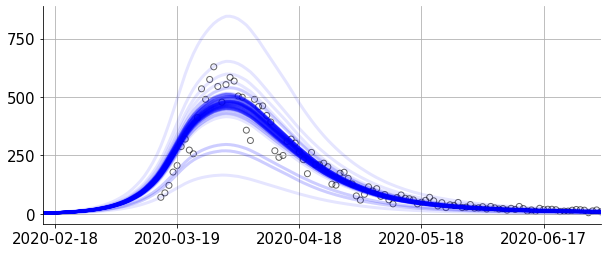

In [42]:
end_sim = '2020-07-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(100):
    # Sampling
    idx, model.parameters['beta'] = random.choice(list(enumerate(samples_dict_wave1['beta'])))
    model.parameters['l'] = samples_dict_wave1['l'][idx] 
    model.parameters['tau'] = samples_dict_wave1['tau'][idx]    
    model.parameters['prev_schools'] = samples_dict_wave1['prev_schools'][idx]    
    model.parameters['prev_work'] = samples_dict_wave1['prev_work'][idx]     
    model.parameters['prev_transport'] = samples_dict_wave1['prev_transport'][idx]    
    model.parameters['prev_leisure'] = samples_dict_wave1['prev_leisure'][idx]     
    model.parameters['prev_others'] = samples_dict_wave1['prev_others'][idx]      

    # Simulate
    y_model = model.sim(end_sim,start_date=start_calibration,warmup=theta_pso[-1])
    # Plot
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.1)

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-02-15',end_sim)
fig.savefig(fig_path+'others/FIT_WAVE1_GOOGLE_'+spatial_unit+'_'+str(datetime.date.today())+'.pdf', dpi=400, bbox_inches='tight')

## Visualizations

### Goodness-of-fit: $\beta$, $l$ and $\tau$

In [ ]:
old_theta = {name:par for name,par in zip(parNames, theta) } 
old_theta

In [ ]:
params.update({'samples_dict': samples_dict})

# Re-initialize the model
model = models.COVID19_SEIRD(initial_states, params, time_dependent_parameters={'Nc': google_lockdown, 'beta': switch_beta})

In [ ]:
end_sim = end_calibration

fig,ax=plt.subplots(figsize=(10,4))
for i in range(10):
    # Sampling
    idx, model.parameters['beta'] = random.choice(list(enumerate(samples_dict_wave1['beta'])))
    model.parameters['l'] = samples_dict_wave1['l'][idx] 
    model.parameters['tau'] = samples_dict_wave1['tau'][idx]    
    model.parameters['prev_schools'] = samples_dict_wave1['prev_schools'][idx]    
    model.parameters['prev_work'] = samples_dict_wave1['prev_work'][idx]     
    model.parameters['prev_transport'] = samples_dict_wave1['prev_transport'][idx]    
    model.parameters['prev_leisure'] = samples_dict_wave1['prev_leisure'][idx]     
    model.parameters['prev_others'] = samples_dict_wave1['prev_others'][idx]      

    # Simulate
    y_model = model.sim(end_sim,start_date=start_calibration,warmup=51)
    # Plot
    ax.plot(y_model['time'],y_model["H_in"].sum(dim="Nc"),color='blue',alpha=0.1)

ax.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration],color='black',alpha=0.6,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
ax.set_xlim('2020-03-15',end_sim)
#plt.savefig(fig_path+'others/FIT_WAVE1_GOOGLE_'+spatial_unit+'_'+str(datetime.date.today())+'.pdf', dpi=400, bbox_inches='tight')

### $R_0$

In [ ]:
fig,ax=plt.subplots(figsize=(10,4))
ax.hist(samples_dict['R0'],bins=30)
plt.savefig(fig_path+'others/R0_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### Seroprelevance

In [ ]:
end_sim = '2020-06-01'

fig,ax=plt.subplots(figsize=(10,4))
for i in range(10):
    model.parameters = draw_sample_COVID19_SEIRD_google(model.parameters,samples_dict)
    y_model = model.sim(end_sim,start_date=start_data,excess_time=samples_dict['warmup'])
    ax.plot((1-y_model["S"].sel(time=end_sim)/y_model["S"].isel(time=0))*100,alpha=0.03,color='blue',linewidth=2)

ax.set_xlabel('age')
ax.set_ylabel("seroprelevance (%)" )
ax.set_ylim()
plt.xticks(np.arange(9), ('[0-10[', '[10-20[', '[20-30[', '[30-40[', '[40-50[', '[50-60[', '[60-70[', '[70-80[', '[80-$\infty$['))

plt.savefig(fig_path+'others/SEROPRELEVANCE_'+end_sim+'_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### Lockdown release

In [ ]:
end_sim = '2020-09-01'
n=100
percentile = 0.99

y_model = model.sim(end_sim,start_date=start_data,excess_time=samples_dict['warmup'],N=n,draw_fcn=draw_sample_COVID19_SEIRD_google,samples=samples_dict)

fig,ax = plt.subplots(figsize=(10,4))
ax.fill_between(pd.to_datetime(y_model['time'].values),y_model["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc"), y_model["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc"),alpha=0.30)
ax.plot(y_model['time'],y_model["H_tot"].mean(dim="draws").sum(dim="Nc"),'--')
ax.scatter(df_sciensano[:end_sim].index,df_sciensano['H_tot'][:end_sim],color='black',alpha=0.4,linestyle='None',facecolors='none')
ax = _apply_tick_locator(ax)
plt.savefig(fig_path+'others/LOCKDOWN_RELEASE_WAVE1_GOOGLE.pdf', dpi=400, bbox_inches='tight',orientation='portrait', papertype='a4')

### Save results to a .csv

In [ ]:
index = y_model['time'].values
columns = ['WAVE1_INCIDENCES_MEAN','WAVE1_INCIDENCES_MEDIAN','WAVE1_INCIDENCES_LL','WAVE1_INCIDENCES_UL']
data = np.transpose(np.array([
        y_model["H_tot"].mean(dim="draws").sum(dim="Nc").values.tolist(),
        y_model["H_tot"].median(dim="draws").sum(dim="Nc").values.tolist(),
        y_model["H_tot"].quantile(1-percentile,dim="draws").sum(dim="Nc").values.tolist(),
        y_model["H_tot"].quantile(percentile,dim="draws").sum(dim="Nc").values.tolist()
       ]))

In [ ]:
df = pd.DataFrame(data,columns=columns,index=index)
df.head()

In [ ]:
df.to_csv('../../results/predictions/FAGG/COVID19_SEIRD/WAVE1.csv',index=True)